In [9]:
import pandas as pd
import numpy as np
from scipy import signal  
import math as m
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import find_peaks

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
df_acc=pd.read_csv('/content/drive/MyDrive/Data 2nd phase/first_data_collected SMOTE Anomaly.csv')

In [12]:
df_acc.head()

,Unnamed: 0,x,y,z,Anomaly
0,0,-0.011964,0.869492,9.841380,unanomaly
1,1,-0.237189,1.142573,9.767203,unanomaly
2,2,-0.320937,1.027717,9.673584,unanomaly
3,3,0.016750,0.862313,9.788738,unanomaly
4,4,-0.115155,1.003789,9.783953,unanomaly


In [13]:
df_acc['Anomaly'].value_counts()

unanomaly    457129
anomaly      457129
Name: Anomaly, dtype: int64

## Reorientation



In [14]:
interp_frame=df_acc

In [15]:
interp_frame['alpha']= (interp_frame['y']/interp_frame['z'])
interp_frame['alpha']= interp_frame['alpha'].apply(m.atan)

In [16]:
interp_frame['beta']= (interp_frame['y']**2 + interp_frame['z']**2 )
interp_frame['beta']= interp_frame['beta'].apply(m.sqrt)
interp_frame['beta']= (-interp_frame['x']/ interp_frame['beta'])
interp_frame['beta']= interp_frame['beta'].apply(m.atan)

In [17]:
def Rx(theta):
    return np.matrix([[ 1, 0           , 0           ],
                   [ 0, m.cos(theta),-m.sin(theta)],
                   [ 0, m.sin(theta), m.cos(theta)]])
  
def Ry(theta):
    return np.matrix([[ m.cos(theta), 0, m.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-m.sin(theta), 0, m.cos(theta)]])
  
def Rz(theta):
    return np.matrix([[ m.cos(theta), -m.sin(theta), 0 ],
                   [ m.sin(theta), m.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])
  
def acc_matrix():
    return np.matrix([[interp_frame['x']],
                    [interp_frame['y']],
                    [interp_frame['z']]])

In [18]:
%%time
x_re=[]
y_re=[]
z_re=[]
for i in range(len(interp_frame)):
    xyz=np.array([[interp_frame['x'].iloc[i]],
                 [interp_frame['y'].iloc[i]],
                 [interp_frame['z'].iloc[i]]])
    xy_reorientation=Ry(interp_frame['beta'].iloc[i]) * Rx(interp_frame['alpha'].iloc[i]) * xyz
    x_re.append(xy_reorientation[0][0])
    y_re.append(xy_reorientation[1][0])
    z_re.append(xy_reorientation[2][0])
# x_re_array,y,z : just conversion
x_re_array=np.array(x_re)
y_re_array=np.array(y_re)
z_re_array=np.array(z_re)

# lists to append values 
x_list=[]
y_list=[]
z_list=[]

for i in range(len(x_re)) :
    x_list.append(x_re_array[i][0][0])
    y_list.append(y_re_array[i][0][0])
    z_list.append(z_re_array[i][0][0])
    

#Dataframe to calc yaw  
stage_2 = pd.DataFrame(
    {'x': x_list,
     'y': y_list,
     'z': z_list
    })
    
#yaw equation
stage_2['yaw']=stage_2['x'] / stage_2['y']
stage_2['yaw']=stage_2['yaw'].apply(m.atan)

#fill na with zeros
stage_2['yaw'].fillna(0,inplace=True)


# final stage of z calculatio
x_re=[]
y_re=[]
z_re=[]
for i in range(len(stage_2)):
    xyz=np.array([[stage_2['x'].iloc[i]],
                 [stage_2['y'].iloc[i]],
                 [stage_2['z'].iloc[i]]])
    z_reorientation=Rz(stage_2['yaw'].iloc[i]) *  xyz
    x_re.append(z_reorientation[0][0])
    y_re.append(z_reorientation[1][0])
    z_re.append(z_reorientation[2][0])
    #print(x_re[i],y_re[i],z_re[i])   
x_re_array=np.array(x_re)
y_re_array=np.array(y_re)
z_re_array=np.array(z_re)
# lists to append values 
x_list=[]
y_list=[]
z_list=[]

for i in range(len(x_re)) :
    x_list.append(x_re_array[i][0][0])
    y_list.append(y_re_array[i][0][0])
    z_list.append(z_re_array[i][0][0])
    
# final results of x' ,y', z'
reorientation_final = pd.DataFrame(
    {'x': x_list,
     'y': y_list,
     'z': z_list
    })


CPU times: user 4min 55s, sys: 11.1 s, total: 5min 6s
Wall time: 5min 9s


In [19]:
reorientation_final.head()

,x,y,z
0,-1.478198e-35,-3.627460e-17,9.879723
1,-1.106544e-34,-4.382619e-17,9.836666
2,-3.791050e-34,-2.003538e-16,9.733316
3,1.772860e-35,-1.426557e-16,9.826661
4,-1.767518e-34,-6.650678e-17,9.835984


# Filter 

In [20]:

reorientation_final['x_Filtered'] = np.nan
reorientation_final['y_Filtered'] = np.nan
reorientation_final['z_Filtered'] = np.nan


In [21]:
sos = signal.butter(10, 15, 'hp',fs = 1000, output= 'sos')
reorientation_final['x_Filtered'] = signal.sosfilt(sos, reorientation_final['x'])
reorientation_final['y_Filtered'] = signal.sosfilt(sos, reorientation_final['y'])
reorientation_final['z_Filtered'] = signal.sosfilt(sos, reorientation_final['z'])
reorientation_final.head(20)

,x,y,z,x_Filtered,y_Filtered,z_Filtered
0,-1.478198e-35,-3.627460e-17,9.879723,-1.093562e-35,-2.683573e-17,7.308960
1,-1.106544e-34,-4.382619e-17,9.836666,-7.527320e-35,-1.625491e-17,2.873754
2,-3.791050e-34,-2.003538e-16,9.733316,-2.265478e-34,-1.174148e-16,-0.253710
3,1.772860e-35,-1.426557e-16,9.826661,2.194646e-34,4.734599e-18,-2.128217
4,-1.767518e-34,-6.650678e-17,9.835984,3.322505e-36,8.979716e-17,-3.285240
5,2.263477e-33,1.235932e-16,9.826529,1.838434e-33,2.130816e-16,-3.815686
6,-6.481692e-36,-6.030026e-17,9.751453,-9.118214e-34,-2.410948e-17,-3.906403
7,5.726321e-36,-7.261004e-17,9.828132,-6.428235e-34,-2.552022e-17,-3.503907
8,4.645533e-33,-1.775290e-16,9.883973,2.994039e-33,-9.279445e-17,-2.925113
9,8.765379e-34,-8.460796e-17,9.753419,-1.699205e-33,2.926364e-17,-2.361699


# Labeling

In [22]:
df_acc.columns

Index(['Unnamed: 0', 'x', 'y', 'z', 'Anomaly', 'alpha', 'beta'], dtype='object')

In [23]:
reorientation_final['Anomaly'] = interp_frame['Anomaly']
# reorientation_final['speed'] = interp_frame['speed']
# reorientation_final['latitude'] = interp_frame['latitude']
# reorientation_final['longitude'] = interp_frame['longitude']

# Segmentation


In [24]:
df=reorientation_final

In [25]:
df.drop(df.tail(500).index,inplace=True) 
df.drop(df.head(300).index,inplace=True)

In [26]:
df['Anomaly'].value_counts()/100

unanomaly    4568.29
anomaly      4566.29
Name: Anomaly, dtype: float64

## segmentation for train


In [27]:
%%time
from math import sqrt
##################### lists #################################
speed_list = []
Anomaly_labels_common = []
Anomaly_Type_labels_common = []
x_list_common=[]
y_list_common=[]
z_list_common=[]


################### Start windowing ##################################
window_size = 100
step_size = 50
# creating overlaping windows of size window-size 100
for i in range(0,df.shape[0] - window_size,step_size):
    xs = df['x_Filtered'].values[i: i + 100]
    ys = df['y_Filtered'].values[i: i + 100]
    zs = df['z_Filtered'].values[i: i + 100] 
    label_anom = df['Anomaly'].values[i: i + 100]
#### Appending in list after check  un anomalies label for each list ##############
    if np.count_nonzero(label_anom == 'anomaly') ==0 :
        x_list_common.append(xs) 
        y_list_common.append(ys) 
        z_list_common.append(zs)
        Anomaly_labels_common.append('unanomaly')
  #### Appending in list after check anomalies label for each list ##############
    elif np.count_nonzero(label_anom == 'anomaly') >39  :
        x_list_common.append(xs) 
        y_list_common.append(ys) 
        z_list_common.append(zs)
        Anomaly_labels_common.append('anomaly')
                   
    else:
        continue


CPU times: user 506 ms, sys: 7.55 ms, total: 514 ms
Wall time: 515 ms


# Counter

In [28]:
from collections import Counter
Counter(Anomaly_labels_common)

Counter({'anomaly': 9351, 'unanomaly': 7216})

In [29]:
x_list=x_list_common
y_list=y_list_common
z_list=z_list_common
Anomaly_labels=Anomaly_labels_common
# Anomaly_Type_labels=Anomaly_Type_labels_common
# long_list=long
# lat_list=lat
# s_list=speed_list

0.37961354447187323

# Feature Extraction

## Time Domain

In [31]:
!pip install antropy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
%%time
import statistics
import antropy as ent
# Statistical Features on raw x, y and z in time domain
X_train = pd.DataFrame()

# mean
X_train['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_train['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_train['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())
# std dev
X_train['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_train['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_train['z_std'] = pd.Series(z_list).apply(lambda x: x.std())
# min
X_train['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_train['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_train['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_train['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_train['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_train['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X_train['x_maxmin_diff'] = X_train['x_max'] - X_train['x_min']
X_train['y_maxmin_diff'] = X_train['y_max'] - X_train['y_min']
X_train['z_maxmin_diff'] = X_train['z_max'] - X_train['z_min']

# median
X_train['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_train['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X_train['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# Variance
X_train['x_variance'] = pd.Series(x_list).apply(lambda x: statistics.variance(x))
X_train['y_variance'] = pd.Series(y_list).apply(lambda x: statistics.variance(x))
X_train['z_variance'] = pd.Series(z_list).apply(lambda x: statistics.variance(x))

# kurtosis
X_train['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_train['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_train['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

# entropy
X_train['x_entropy'] = pd.Series(x_list).apply(lambda x: ent.perm_entropy(x,normalize=True))
X_train['y_entropy'] = pd.Series(y_list).apply(lambda x: ent.perm_entropy(x,normalize=True))
X_train['z_entropy'] = pd.Series(z_list).apply(lambda x: ent.perm_entropy(x,normalize=True))

# 5th interquartile range
X_train['x_IQR_5th'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 5))
X_train['y_IQR_5th'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 5))
X_train['z_IQR_5th'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 5))

# 25th interquartile range
X_train['x_IQR_25th'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 25))
X_train['y_IQR_25th'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 25))
X_train['z_IQR_25th'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 25))

# 75th interquartile range
X_train['x_IQR_75th'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75))
X_train['y_IQR_75th'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75))
X_train['z_IQR_75th'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75))

# 95th interquartile range
X_train['x_IQR_95th'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 95))
X_train['y_IQR_95th'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 95))
X_train['z_IQR_95th'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 95))

# RMS
X_train['x_RMS'] = pd.Series(x_list).apply(lambda x: np.sqrt(np.mean(x**2)))
X_train['y_RMS'] = pd.Series(y_list).apply(lambda x: np.sqrt(np.mean(x**2)))
X_train['z_RMS'] = pd.Series(z_list).apply(lambda x: np.sqrt(np.mean(x**2)))

# skewness
X_train['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_train['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_train['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

#  number of zero crossing 
X_train['x_no_zero_cross'] = pd.Series(x_list).apply(lambda x: ((x[:-1] * x[1:]) < 0).sum())
X_train['y_no_zero_cross'] = pd.Series(y_list).apply(lambda x: ((x[:-1] * x[1:]) < 0).sum())
X_train['z_no_zero_cross'] = pd.Series(z_list).apply(lambda x: ((x[:-1] * x[1:]) < 0).sum())
#  number of mean crossing 
X_train['x_no_mean_cross'] = pd.Series(x_list).apply(lambda x: ((x[:-1] * x[1:]) < np.mean(x)).sum())
X_train['y_no_mean_cross'] = pd.Series(y_list).apply(lambda x: ((x[:-1] * x[1:]) < np.mean(x)).sum())
X_train['z_no_mean_cross'] = pd.Series(z_list).apply(lambda x: ((x[:-1] * x[1:]) < np.mean(x)).sum())                                                     


CPU times: user 1min 53s, sys: 343 ms, total: 1min 53s
Wall time: 2min 1s


In [33]:
X_train.shape

(16567, 51)

In [34]:
X_train.columns

Index(['x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std', 'z_std', 'x_min',
       'y_min', 'z_min', 'x_max', 'y_max', 'z_max', 'x_maxmin_diff',
       'y_maxmin_diff', 'z_maxmin_diff', 'x_median', 'y_median', 'z_median',
       'x_variance', 'y_variance', 'z_variance', 'x_kurtosis', 'y_kurtosis',
       'z_kurtosis', 'x_entropy', 'y_entropy', 'z_entropy', 'x_IQR_5th',
       'y_IQR_5th', 'z_IQR_5th', 'x_IQR_25th', 'y_IQR_25th', 'z_IQR_25th',
       'x_IQR_75th', 'y_IQR_75th', 'z_IQR_75th', 'x_IQR_95th', 'y_IQR_95th',
       'z_IQR_95th', 'x_RMS', 'y_RMS', 'z_RMS', 'x_skewness', 'y_skewness',
       'z_skewness', 'x_no_zero_cross', 'y_no_zero_cross', 'z_no_zero_cross',
       'x_no_mean_cross', 'y_no_mean_cross', 'z_no_mean_cross'],
      dtype='object')

## Frequency Domain

In [35]:
t_n = 10
N = 100
T = t_n / N
f_s = 1/T


In [36]:
# converting the signals from time domain to frequency domain using FFT fn
from scipy.fft import fft
def get_fft_values(y_values, T, N, f_s):
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return  fft_values

In [37]:
# converting the signals from time domain to frequency domain using PSD fn
from scipy.signal import welch

def get_psd_values(y_values, T, N, f_s):
    f_value,psd_values = welch(y_values, fs=f_s)
    return  psd_values

In [38]:
# converting the signals from time domain to frequency domain using Autocorr fn
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]
 
def get_autocorr_values(y_values, T, N, f_s):
    autocorr_values = autocorr(y_values)
    return  autocorr_values

In [39]:
# function gain width and height peaks
from scipy.signal import  peak_widths
from itertools import islice
def take(n, iterable):
    return list(islice(iterable, n))
def hig_wid_peak(signal):
    signal_peak=find_peaks(signal)[0]
    Peak_ind_signal_value={}
    for i in signal_peak:
        Peak_ind_signal_value[i]=[]
        Peak_ind_signal_value[i].append(signal[i])
    sorted_dic={k: v for k, v in sorted(Peak_ind_signal_value.items(), key=lambda item: item[1],reverse=True)}
    if len(sorted_dic)<5:
        first_5_sorted=list(sorted_dic.items())
    else:
        first_5_sorted=take(5, sorted_dic.items())
    peak_ind=[]
    peak_height=[]
    for i in range(len(first_5_sorted)):
        peak_ind.append(first_5_sorted[i][0])
        peak_height.append(abs(first_5_sorted[i][1][0]))
    peak_width=peak_widths(signal,peak_ind,rel_height=1)
    peak_width_list=peak_width[0]
    peak_height_final=[]
    peak_width_final=[]
    for i in range(0,5):
        try:
            peak_height_final.append(peak_height[i])
            peak_width_final.append(peak_width_list[i])
        except:
            peak_height_final.append(0)
            peak_width_final.append(0)
    return peak_height_final,peak_width_final    

In [40]:
def AppendInDF(signal,column_name):
    list_height_1=[]
    list_height_2=[]
    list_height_3=[]
    list_height_4=[]
    list_height_5=[]
    ################################################
    list_width_1=[]
    list_width_2=[]
    list_width_3=[]
    list_width_4=[]
    list_width_5=[]
    ################################################
    for i in range(len(signal)):
        list_height_1.append(signal[i][0][0])
        list_height_2.append(signal[i][0][1])
        list_height_3.append(signal[i][0][2])
        list_height_4.append(signal[i][0][3])
        list_height_5.append(signal[i][0][4])
 #####################################################       
        list_width_1.append(signal[i][1][0])
        list_width_2.append(signal[i][1][1])
        list_width_3.append(signal[i][1][2])
        list_width_4.append(signal[i][1][3])
        list_width_5.append(signal[i][1][4])
  #####################################################      
    X_train[column_name+'_height_'+str(1)]=list_height_1
    X_train[column_name+'_height_'+str(2)]=list_height_2 
    X_train[column_name+'_height_'+str(3)]=list_height_3 
    X_train[column_name+'_height_'+str(4)]=list_height_4 
    X_train[column_name+'_height_'+str(5)]=list_height_5
#######################################################
    X_train[column_name+'_width_'+str(1)]=list_width_1
    X_train[column_name+'_width_'+str(2)]=list_width_2 
    X_train[column_name+'_width_'+str(3)]=list_width_3 
    X_train[column_name+'_width_'+str(4)]=list_width_4 
    X_train[column_name+'_width_'+str(5)]=list_width_5 

In [41]:
%%time
# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: get_fft_values(x, T, N, f_s))
y_list_fft = pd.Series(y_list).apply(lambda x: get_fft_values(x, T, N, f_s))
z_list_fft = pd.Series(z_list).apply(lambda x: get_fft_values(x, T, N, f_s))
# converting the signals from time domain to frequency domain using PSD
x_list_PSD = pd.Series(x_list).apply(lambda x: get_psd_values(x, T, N, f_s))
y_list_PSD = pd.Series(y_list).apply(lambda x: get_psd_values(x, T, N, f_s))
z_list_PSD = pd.Series(z_list).apply(lambda x: get_psd_values(x, T, N, f_s))
# converting the signals from time domain to frequency domain using autocorr
x_list_autocorr = pd.Series(x_list).apply(lambda x: get_autocorr_values(x, T, N, f_s))
y_list_autocorr = pd.Series(y_list).apply(lambda x: get_autocorr_values(x, T, N, f_s))
z_list_autocorr = pd.Series(z_list).apply(lambda x: get_autocorr_values(x, T, N, f_s))

CPU times: user 18.5 s, sys: 215 ms, total: 18.7 s
Wall time: 22.1 s


In [42]:
%%time
x_list_fft_phw=pd.Series(x_list_fft).apply(lambda x: hig_wid_peak(x))
y_list_fft_phw=pd.Series(y_list_fft).apply(lambda x: hig_wid_peak(x))
z_list_fft_phw=pd.Series(z_list_fft).apply(lambda x: hig_wid_peak(x))

CPU times: user 6.76 s, sys: 86.8 ms, total: 6.85 s
Wall time: 9.65 s


In [43]:
%%time
AppendInDF(x_list_fft_phw,'x_fft')
AppendInDF(y_list_fft_phw,'y_fft')
AppendInDF(z_list_fft_phw,'z_fft')

CPU times: user 3.24 s, sys: 22.9 ms, total: 3.26 s
Wall time: 4.02 s


In [44]:
%%time
x_list_PSD_phw=pd.Series(x_list_PSD).apply(lambda x: hig_wid_peak(x))
y_list_PSD_phw=pd.Series(y_list_PSD).apply(lambda x: hig_wid_peak(x))
z_list_PSD_phw=pd.Series(z_list_PSD).apply(lambda x: hig_wid_peak(x))

CPU times: user 5.39 s, sys: 162 ms, total: 5.56 s
Wall time: 6.5 s


In [45]:
%%time
AppendInDF(x_list_PSD_phw,'x_PSD')
AppendInDF(y_list_PSD_phw,'y_PSD')
AppendInDF(z_list_PSD_phw,'z_PSD')

CPU times: user 1.68 s, sys: 3.78 ms, total: 1.68 s
Wall time: 1.68 s


In [46]:
%%time
x_list_autocorr_phw=pd.Series(x_list_autocorr).apply(lambda x: hig_wid_peak(x))
y_list_autocorr_phw=pd.Series(y_list_autocorr).apply(lambda x: hig_wid_peak(x))
z_list_autocorr_phw=pd.Series(z_list_autocorr).apply(lambda x: hig_wid_peak(x))

CPU times: user 6.71 s, sys: 428 ms, total: 7.14 s
Wall time: 6.69 s


In [47]:
%%time
AppendInDF(x_list_autocorr_phw,'x_autocorr')
AppendInDF(y_list_autocorr_phw,'y_autocorr')
AppendInDF(z_list_autocorr_phw,'z_autocorr')

CPU times: user 1.68 s, sys: 6.61 ms, total: 1.69 s
Wall time: 1.7 s


## Wavelet Domain

In [48]:
from pywt import wavedec
x_list_rbio = pd.Series(x_list).apply(lambda x: wavedec(x, 'rbio3.1', level = 3))
y_list_rbio = pd.Series(y_list).apply(lambda x: wavedec(x, 'rbio3.1', level = 3))
z_list_rbio = pd.Series(z_list).apply(lambda x: wavedec(x, 'rbio3.1', level = 3))

In [49]:
%%time
x_list_rbio_cA1=[]
x_list_rbio_cD3=[]
x_list_rbio_cD2=[]
x_list_rbio_cD1=[]
################################################
for i in range(len(x_list_rbio)):
    x_list_rbio_cA1.append(x_list_rbio[i][0])
    x_list_rbio_cD3.append(x_list_rbio[i][1])
    x_list_rbio_cD2.append(x_list_rbio[i][2])
    x_list_rbio_cD1.append(x_list_rbio[i][3])

CPU times: user 230 ms, sys: 848 µs, total: 231 ms
Wall time: 232 ms


In [50]:
%%time
y_list_rbio_cA1=[]
y_list_rbio_cD3=[]
y_list_rbio_cD2=[]
y_list_rbio_cD1=[]
################################################
for i in range(len(y_list_rbio)):
    y_list_rbio_cA1.append(y_list_rbio[i][0])
    y_list_rbio_cD3.append(y_list_rbio[i][1])
    y_list_rbio_cD2.append(y_list_rbio[i][2])
    y_list_rbio_cD1.append(y_list_rbio[i][3])

CPU times: user 222 ms, sys: 0 ns, total: 222 ms
Wall time: 223 ms


In [51]:
%%time
z_list_rbio_cA1=[]
z_list_rbio_cD3=[]
z_list_rbio_cD2=[]
z_list_rbio_cD1=[]
################################################
for i in range(len(y_list_rbio)):
    z_list_rbio_cA1.append(z_list_rbio[i][0])
    z_list_rbio_cD3.append(z_list_rbio[i][1])
    z_list_rbio_cD2.append(z_list_rbio[i][2])
    z_list_rbio_cD1.append(z_list_rbio[i][3])

CPU times: user 217 ms, sys: 2.58 ms, total: 220 ms
Wall time: 220 ms


In [52]:
%%time
import statistics
import antropy as ent


# mean
X_train['x_rbio_cA1_mean'] = pd.Series(x_list_rbio_cA1).apply(lambda x: x.mean())
X_train['x_rbio_cD3_mean'] = pd.Series(x_list_rbio_cD3).apply(lambda x: x.mean())
X_train['x_rbio_cD2_mean'] = pd.Series(x_list_rbio_cD2).apply(lambda x: x.mean())
X_train['x_rbio_cD1_mean'] = pd.Series(x_list_rbio_cD1).apply(lambda x: x.mean())
#####################################################################################
X_train['y_rbio_cA1_mean'] = pd.Series(y_list_rbio_cA1).apply(lambda x: x.mean())
X_train['y_rbio_cD3_mean'] = pd.Series(y_list_rbio_cD3).apply(lambda x: x.mean())
X_train['y_rbio_cD2_mean'] = pd.Series(y_list_rbio_cD2).apply(lambda x: x.mean())
X_train['y_rbio_cD1_mean'] = pd.Series(y_list_rbio_cD1).apply(lambda x: x.mean())
#####################################################################################
X_train['z_rbio_cA1_mean'] = pd.Series(z_list_rbio_cA1).apply(lambda x: x.mean())
X_train['z_rbio_cD3_mean'] = pd.Series(z_list_rbio_cD3).apply(lambda x: x.mean())
X_train['z_rbio_cD2_mean'] = pd.Series(z_list_rbio_cD2).apply(lambda x: x.mean())
X_train['z_rbio_cD1_mean'] = pd.Series(z_list_rbio_cD1).apply(lambda x: x.mean())

# std dev
X_train['x_rbio_cA1_std'] = pd.Series(x_list_rbio_cA1).apply(lambda x: x.std())
X_train['x_rbio_cD3_std'] = pd.Series(x_list_rbio_cD3).apply(lambda x: x.std())
X_train['x_rbio_cD2_std'] = pd.Series(x_list_rbio_cD2).apply(lambda x: x.std())
X_train['x_rbio_cD1_std'] = pd.Series(x_list_rbio_cD1).apply(lambda x: x.std())
#####################################################################################
X_train['y_rbio_cA1_std'] = pd.Series(y_list_rbio_cA1).apply(lambda x: x.std())
X_train['y_rbio_cD3_std'] = pd.Series(y_list_rbio_cD3).apply(lambda x: x.std())
X_train['y_rbio_cD2_std'] = pd.Series(y_list_rbio_cD2).apply(lambda x: x.std())
X_train['y_rbio_cD1_std'] = pd.Series(y_list_rbio_cD1).apply(lambda x: x.std())
#####################################################################################
X_train['z_rbio_cA1_std'] = pd.Series(z_list_rbio_cA1).apply(lambda x: x.std())
X_train['z_rbio_cD3_std'] = pd.Series(z_list_rbio_cD3).apply(lambda x: x.std())
X_train['z_rbio_cD2_std'] = pd.Series(z_list_rbio_cD2).apply(lambda x: x.std())
X_train['z_rbio_cD1_std'] = pd.Series(z_list_rbio_cD1).apply(lambda x: x.std())

# min
X_train['x_rbio_cA1_min'] = pd.Series(x_list_rbio_cA1).apply(lambda x: x.min())
X_train['x_rbio_cD3_min'] = pd.Series(x_list_rbio_cD3).apply(lambda x: x.min())
X_train['x_rbio_cD2_min'] = pd.Series(x_list_rbio_cD2).apply(lambda x: x.min())
X_train['x_rbio_cD1_min'] = pd.Series(x_list_rbio_cD1).apply(lambda x: x.min())
#####################################################################################
X_train['y_rbio_cA1_min'] = pd.Series(y_list_rbio_cA1).apply(lambda x: x.min())
X_train['y_rbio_cD3_min'] = pd.Series(y_list_rbio_cD3).apply(lambda x: x.min())
X_train['y_rbio_cD2_min'] = pd.Series(y_list_rbio_cD2).apply(lambda x: x.min())
X_train['y_rbio_cD1_min'] = pd.Series(y_list_rbio_cD1).apply(lambda x: x.min())
#####################################################################################
X_train['z_rbio_cA1_min'] = pd.Series(z_list_rbio_cA1).apply(lambda x: x.min())
X_train['z_rbio_cD3_min'] = pd.Series(z_list_rbio_cD3).apply(lambda x: x.min())
X_train['z_rbio_cD2_min'] = pd.Series(z_list_rbio_cD2).apply(lambda x: x.min())
X_train['z_rbio_cD1_min'] = pd.Series(z_list_rbio_cD1).apply(lambda x: x.min())


# max
X_train['x_rbio_cA1_max'] = pd.Series(x_list_rbio_cA1).apply(lambda x: x.max())
X_train['x_rbio_cD3_max'] = pd.Series(x_list_rbio_cD3).apply(lambda x: x.max())
X_train['x_rbio_cD2_max'] = pd.Series(x_list_rbio_cD2).apply(lambda x: x.max())
X_train['x_rbio_cD1_max'] = pd.Series(x_list_rbio_cD1).apply(lambda x: x.max())
#####################################################################################
X_train['y_rbio_cA1_max'] = pd.Series(y_list_rbio_cA1).apply(lambda x: x.max())
X_train['y_rbio_cD3_max'] = pd.Series(y_list_rbio_cD3).apply(lambda x: x.max())
X_train['y_rbio_cD2_max'] = pd.Series(y_list_rbio_cD2).apply(lambda x: x.max())
X_train['y_rbio_cD1_max'] = pd.Series(y_list_rbio_cD1).apply(lambda x: x.max())
#####################################################################################
X_train['z_rbio_cA1_max'] = pd.Series(z_list_rbio_cA1).apply(lambda x: x.max())
X_train['z_rbio_cD3_max'] = pd.Series(z_list_rbio_cD3).apply(lambda x: x.max())
X_train['z_rbio_cD2_max'] = pd.Series(z_list_rbio_cD2).apply(lambda x: x.max())
X_train['z_rbio_cD1_max'] = pd.Series(z_list_rbio_cD1).apply(lambda x: x.max())

# max-min diff
X_train['x_rbio_cA1_maxmin_diff'] = X_train['x_rbio_cA1_max'] - X_train['x_rbio_cA1_min']
X_train['x_rbio_cD3_maxmin_diff'] = X_train['x_rbio_cD3_max'] - X_train['x_rbio_cD3_min']
X_train['x_rbio_cD2_maxmin_diff'] = X_train['x_rbio_cD2_max'] - X_train['x_rbio_cD2_min']
X_train['x_rbio_cD1_maxmin_diff'] = X_train['x_rbio_cD1_max'] - X_train['x_rbio_cD1_min']
#####################################################################################
X_train['y_rbio_cA1_maxmin_diff'] = X_train['y_rbio_cA1_max'] - X_train['y_rbio_cA1_min']
X_train['y_rbio_cD3_maxmin_diff'] = X_train['y_rbio_cD3_max'] - X_train['y_rbio_cD3_min']
X_train['y_rbio_cD2_maxmin_diff'] = X_train['y_rbio_cD2_max'] - X_train['y_rbio_cD2_min']
X_train['y_rbio_cD1_maxmin_diff'] = X_train['y_rbio_cD1_max'] - X_train['y_rbio_cD1_min']
#####################################################################################
X_train['z_rbio_cA1_maxmin_diff'] = X_train['z_rbio_cA1_max'] - X_train['z_rbio_cA1_min']
X_train['z_rbio_cD3_maxmin_diff'] = X_train['z_rbio_cD3_max'] - X_train['z_rbio_cD3_min']
X_train['z_rbio_cD2_maxmin_diff'] = X_train['z_rbio_cD2_max'] - X_train['z_rbio_cD2_min']
X_train['z_rbio_cD1_maxmin_diff'] = X_train['z_rbio_cD1_max'] - X_train['z_rbio_cD1_min']

# median
X_train['x_rbio_cA1_median'] = pd.Series(x_list_rbio_cA1).apply(lambda x: np.median(x))
X_train['x_rbio_cD3_median'] = pd.Series(x_list_rbio_cD3).apply(lambda x: np.median(x))
X_train['x_rbio_cD2_median'] = pd.Series(x_list_rbio_cD2).apply(lambda x: np.median(x))
X_train['x_rbio_cD1_median'] = pd.Series(x_list_rbio_cD1).apply(lambda x: np.median(x))
#####################################################################################
X_train['y_rbio_cA1_median'] = pd.Series(y_list_rbio_cA1).apply(lambda x: np.median(x))
X_train['y_rbio_cD3_median'] = pd.Series(y_list_rbio_cD3).apply(lambda x: np.median(x))
X_train['y_rbio_cD2_median'] = pd.Series(y_list_rbio_cD2).apply(lambda x: np.median(x))
X_train['y_rbio_cD1_median'] = pd.Series(y_list_rbio_cD1).apply(lambda x: np.median(x))
#####################################################################################
X_train['z_rbio_cA1_median'] = pd.Series(z_list_rbio_cA1).apply(lambda x: np.median(x))
X_train['z_rbio_cD3_median'] = pd.Series(z_list_rbio_cD3).apply(lambda x: np.median(x))
X_train['z_rbio_cD2_median'] = pd.Series(z_list_rbio_cD2).apply(lambda x: np.median(x))
X_train['z_rbio_cD1_median'] = pd.Series(z_list_rbio_cD1).apply(lambda x: np.median(x))

# Variance
X_train['x_rbio_cA1_variance'] = pd.Series(x_list_rbio_cA1).apply(lambda x: statistics.variance(x))
X_train['x_rbio_cD3_variance'] = pd.Series(x_list_rbio_cD3).apply(lambda x: statistics.variance(x))
X_train['x_rbio_cD2_variance'] = pd.Series(x_list_rbio_cD2).apply(lambda x: statistics.variance(x))
X_train['x_rbio_cD1_variance'] = pd.Series(x_list_rbio_cD1).apply(lambda x: statistics.variance(x))
#####################################################################################
X_train['y_rbio_cA1_variance'] = pd.Series(y_list_rbio_cA1).apply(lambda x: statistics.variance(x))
X_train['y_rbio_cD3_variance'] = pd.Series(y_list_rbio_cD3).apply(lambda x: statistics.variance(x))
X_train['y_rbio_cD2_variance'] = pd.Series(y_list_rbio_cD2).apply(lambda x: statistics.variance(x))
X_train['y_rbio_cD1_variance'] = pd.Series(y_list_rbio_cD1).apply(lambda x: statistics.variance(x))
#####################################################################################
X_train['z_rbio_cA1_variance'] = pd.Series(z_list_rbio_cA1).apply(lambda x: statistics.variance(x))
X_train['z_rbio_cD3_variance'] = pd.Series(z_list_rbio_cD3).apply(lambda x: statistics.variance(x))
X_train['z_rbio_cD2_variance'] = pd.Series(z_list_rbio_cD2).apply(lambda x: statistics.variance(x))
X_train['z_rbio_cD1_variance'] = pd.Series(z_list_rbio_cD1).apply(lambda x: statistics.variance(x))

# kurtosis
X_train['x_rbio_cA1_kurtosis'] = pd.Series(x_list_rbio_cA1).apply(lambda x: stats.kurtosis(x))
X_train['x_rbio_cD3_kurtosis'] = pd.Series(x_list_rbio_cD3).apply(lambda x: stats.kurtosis(x))
X_train['x_rbio_cD2_kurtosis'] = pd.Series(x_list_rbio_cD2).apply(lambda x: stats.kurtosis(x))
X_train['x_rbio_cD1_kurtosis'] = pd.Series(x_list_rbio_cD1).apply(lambda x: stats.kurtosis(x))
#####################################################################################
X_train['y_rbio_cA1_kurtosis'] = pd.Series(y_list_rbio_cA1).apply(lambda x: stats.kurtosis(x))
X_train['y_rbio_cD3_kurtosis'] = pd.Series(y_list_rbio_cD3).apply(lambda x: stats.kurtosis(x))
X_train['y_rbio_cD2_kurtosis'] = pd.Series(y_list_rbio_cD2).apply(lambda x: stats.kurtosis(x))
X_train['y_rbio_cD1_kurtosis'] = pd.Series(y_list_rbio_cD1).apply(lambda x: stats.kurtosis(x))
#####################################################################################
X_train['z_rbio_cA1_kurtosis'] = pd.Series(z_list_rbio_cA1).apply(lambda x: stats.kurtosis(x))
X_train['z_rbio_cD3_kurtosis'] = pd.Series(z_list_rbio_cD3).apply(lambda x: stats.kurtosis(x))
X_train['z_rbio_cD2_kurtosis'] = pd.Series(z_list_rbio_cD2).apply(lambda x: stats.kurtosis(x))
X_train['z_rbio_cD1_kurtosis'] = pd.Series(z_list_rbio_cD1).apply(lambda x: stats.kurtosis(x))


# entropy
X_train['x_rbio_cA1_entropy'] = pd.Series(x_list_rbio_cA1).apply(lambda x: ent.perm_entropy(x,normalize=True))
X_train['x_rbio_cD3_entropy'] = pd.Series(x_list_rbio_cD3).apply(lambda x: ent.perm_entropy(x,normalize=True))
X_train['x_rbio_cD2_entropy'] = pd.Series(x_list_rbio_cD2).apply(lambda x: ent.perm_entropy(x,normalize=True))
X_train['x_rbio_cD1_entropy'] = pd.Series(x_list_rbio_cD1).apply(lambda x: ent.perm_entropy(x,normalize=True))
#####################################################################################
X_train['y_rbio_cA1_entropy'] = pd.Series(y_list_rbio_cA1).apply(lambda x: ent.perm_entropy(x,normalize=True))
X_train['y_rbio_cD3_entropy'] = pd.Series(y_list_rbio_cD3).apply(lambda x: ent.perm_entropy(x,normalize=True))
X_train['y_rbio_cD2_entropy'] = pd.Series(y_list_rbio_cD2).apply(lambda x: ent.perm_entropy(x,normalize=True))
X_train['y_rbio_cD1_entropy'] = pd.Series(y_list_rbio_cD1).apply(lambda x: ent.perm_entropy(x,normalize=True))
#####################################################################################
X_train['z_rbio_cA1_entropy'] = pd.Series(z_list_rbio_cA1).apply(lambda x: ent.perm_entropy(x,normalize=True))
X_train['z_rbio_cD3_entropy'] = pd.Series(z_list_rbio_cD3).apply(lambda x: ent.perm_entropy(x,normalize=True))
X_train['z_rbio_cD2_entropy'] = pd.Series(z_list_rbio_cD2).apply(lambda x: ent.perm_entropy(x,normalize=True))
X_train['z_rbio_cD1_entropy'] = pd.Series(z_list_rbio_cD1).apply(lambda x: ent.perm_entropy(x,normalize=True))


# 5th interquartile range
X_train['x_rbio_cA1_IQR_5th'] = pd.Series(x_list_rbio_cA1).apply(lambda x: np.percentile(x, 5))
X_train['x_rbio_cD3_IQR_5th'] = pd.Series(x_list_rbio_cD3).apply(lambda x: np.percentile(x, 5))
X_train['x_rbio_cD2_IQR_5th'] = pd.Series(x_list_rbio_cD2).apply(lambda x: np.percentile(x, 5))
X_train['x_rbio_cD1_IQR_5th'] = pd.Series(x_list_rbio_cD1).apply(lambda x: np.percentile(x, 5))
#####################################################################################
X_train['y_rbio_cA1_IQR_5th'] = pd.Series(y_list_rbio_cA1).apply(lambda x: np.percentile(x, 5))
X_train['y_rbio_cD3_IQR_5th'] = pd.Series(y_list_rbio_cD3).apply(lambda x: np.percentile(x, 5))
X_train['y_rbio_cD2_IQR_5th'] = pd.Series(y_list_rbio_cD2).apply(lambda x: np.percentile(x, 5))
X_train['y_rbio_cD1_IQR_5th'] = pd.Series(y_list_rbio_cD1).apply(lambda x: np.percentile(x, 5))
#####################################################################################
X_train['z_rbio_cA1_IQR_5th'] = pd.Series(z_list_rbio_cA1).apply(lambda x: np.percentile(x, 5))
X_train['z_rbio_cD3_IQR_5th'] = pd.Series(z_list_rbio_cD3).apply(lambda x: np.percentile(x, 5))
X_train['z_rbio_cD2_IQR_5th'] = pd.Series(z_list_rbio_cD2).apply(lambda x: np.percentile(x, 5))
X_train['z_rbio_cD1_IQR_5th'] = pd.Series(z_list_rbio_cD1).apply(lambda x: np.percentile(x, 5))


# 25th interquartile range
X_train['x_rbio_cA1_IQR_25th'] = pd.Series(x_list_rbio_cA1).apply(lambda x: np.percentile(x, 25))
X_train['x_rbio_cD3_IQR_25th'] = pd.Series(x_list_rbio_cD3).apply(lambda x: np.percentile(x, 25))
X_train['x_rbio_cD2_IQR_25th'] = pd.Series(x_list_rbio_cD2).apply(lambda x: np.percentile(x, 25))
X_train['x_rbio_cD1_IQR_25th'] = pd.Series(x_list_rbio_cD1).apply(lambda x: np.percentile(x, 25))
#####################################################################################
X_train['y_rbio_cA1_IQR_25th'] = pd.Series(y_list_rbio_cA1).apply(lambda x: np.percentile(x, 25))
X_train['y_rbio_cD3_IQR_25th'] = pd.Series(y_list_rbio_cD3).apply(lambda x: np.percentile(x, 25))
X_train['y_rbio_cD2_IQR_25th'] = pd.Series(y_list_rbio_cD2).apply(lambda x: np.percentile(x, 25))
X_train['y_rbio_cD1_IQR_25th'] = pd.Series(y_list_rbio_cD1).apply(lambda x: np.percentile(x, 25))
#####################################################################################
X_train['z_rbio_cA1_IQR_25th'] = pd.Series(z_list_rbio_cA1).apply(lambda x: np.percentile(x, 25))
X_train['z_rbio_cD3_IQR_25th'] = pd.Series(z_list_rbio_cD3).apply(lambda x: np.percentile(x, 25))
X_train['z_rbio_cD2_IQR_25th'] = pd.Series(z_list_rbio_cD2).apply(lambda x: np.percentile(x, 25))
X_train['z_rbio_cD1_IQR_25th'] = pd.Series(z_list_rbio_cD1).apply(lambda x: np.percentile(x, 25))


# 75th interquartile range
X_train['x_rbio_cA1_IQR_75th'] = pd.Series(x_list_rbio_cA1).apply(lambda x: np.percentile(x, 75))
X_train['x_rbio_cD3_IQR_75th'] = pd.Series(x_list_rbio_cD3).apply(lambda x: np.percentile(x, 75))
X_train['x_rbio_cD2_IQR_75th'] = pd.Series(x_list_rbio_cD2).apply(lambda x: np.percentile(x, 75))
X_train['x_rbio_cD1_IQR_75th'] = pd.Series(x_list_rbio_cD1).apply(lambda x: np.percentile(x, 75))
#####################################################################################
X_train['y_rbio_cA1_IQR_75th'] = pd.Series(y_list_rbio_cA1).apply(lambda x: np.percentile(x, 75))
X_train['y_rbio_cD3_IQR_75th'] = pd.Series(y_list_rbio_cD3).apply(lambda x: np.percentile(x, 75))
X_train['y_rbio_cD2_IQR_75th'] = pd.Series(y_list_rbio_cD2).apply(lambda x: np.percentile(x, 75))
X_train['y_rbio_cD1_IQR_75th'] = pd.Series(y_list_rbio_cD1).apply(lambda x: np.percentile(x, 75))
#####################################################################################
X_train['z_rbio_cA1_IQR_75th'] = pd.Series(z_list_rbio_cA1).apply(lambda x: np.percentile(x, 75))
X_train['z_rbio_cD3_IQR_75th'] = pd.Series(z_list_rbio_cD3).apply(lambda x: np.percentile(x, 75))
X_train['z_rbio_cD2_IQR_75th'] = pd.Series(z_list_rbio_cD2).apply(lambda x: np.percentile(x, 75))
X_train['z_rbio_cD1_IQR_75th'] = pd.Series(z_list_rbio_cD1).apply(lambda x: np.percentile(x, 75))


# 95th interquartile range
X_train['x_rbio_cA1_IQR_95th'] = pd.Series(x_list_rbio_cA1).apply(lambda x: np.percentile(x, 95))
X_train['x_rbio_cD3_IQR_95th'] = pd.Series(x_list_rbio_cD3).apply(lambda x: np.percentile(x, 95))
X_train['x_rbio_cD2_IQR_95th'] = pd.Series(x_list_rbio_cD2).apply(lambda x: np.percentile(x, 95))
X_train['x_rbio_cD1_IQR_95th'] = pd.Series(x_list_rbio_cD1).apply(lambda x: np.percentile(x, 95))
#####################################################################################
X_train['y_rbio_cA1_IQR_95th'] = pd.Series(y_list_rbio_cA1).apply(lambda x: np.percentile(x, 95))
X_train['y_rbio_cD3_IQR_95th'] = pd.Series(y_list_rbio_cD3).apply(lambda x: np.percentile(x, 95))
X_train['y_rbio_cD2_IQR_95th'] = pd.Series(y_list_rbio_cD2).apply(lambda x: np.percentile(x, 95))
X_train['y_rbio_cD1_IQR_95th'] = pd.Series(y_list_rbio_cD1).apply(lambda x: np.percentile(x, 95))
#####################################################################################
X_train['z_rbio_cA1_IQR_95th'] = pd.Series(z_list_rbio_cA1).apply(lambda x: np.percentile(x, 95))
X_train['z_rbio_cD3_IQR_95th'] = pd.Series(z_list_rbio_cD3).apply(lambda x: np.percentile(x, 95))
X_train['z_rbio_cD2_IQR_95th'] = pd.Series(z_list_rbio_cD2).apply(lambda x: np.percentile(x, 95))
X_train['z_rbio_cD1_IQR_95th'] = pd.Series(z_list_rbio_cD1).apply(lambda x: np.percentile(x, 95))


# RMS
X_train['x_rbio_cA1_RMS'] = pd.Series(x_list_rbio_cA1).apply(lambda x: np.sqrt(np.mean(x**2)))
X_train['x_rbio_cD3_RMS'] = pd.Series(x_list_rbio_cD3).apply(lambda x: np.sqrt(np.mean(x**2)))
X_train['x_rbio_cD2_RMS'] = pd.Series(x_list_rbio_cD2).apply(lambda x: np.sqrt(np.mean(x**2)))
X_train['x_rbio_cD1_RMS'] = pd.Series(x_list_rbio_cD1).apply(lambda x: np.sqrt(np.mean(x**2)))
#####################################################################################
X_train['y_rbio_cA1_RMS'] = pd.Series(y_list_rbio_cA1).apply(lambda x: np.sqrt(np.mean(x**2)))
X_train['y_rbio_cD3_RMS'] = pd.Series(y_list_rbio_cD3).apply(lambda x: np.sqrt(np.mean(x**2)))
X_train['y_rbio_cD2_RMS'] = pd.Series(y_list_rbio_cD2).apply(lambda x: np.sqrt(np.mean(x**2)))
X_train['y_rbio_cD1_RMS'] = pd.Series(y_list_rbio_cD1).apply(lambda x: np.sqrt(np.mean(x**2)))
#####################################################################################
X_train['z_rbio_cA1_RMS'] = pd.Series(z_list_rbio_cA1).apply(lambda x: np.sqrt(np.mean(x**2)))
X_train['z_rbio_cD3_RMS'] = pd.Series(z_list_rbio_cD3).apply(lambda x: np.sqrt(np.mean(x**2)))
X_train['z_rbio_cD2_RMS'] = pd.Series(z_list_rbio_cD2).apply(lambda x: np.sqrt(np.mean(x**2)))
X_train['z_rbio_cD1_RMS'] = pd.Series(z_list_rbio_cD1).apply(lambda x: np.sqrt(np.mean(x**2)))


# skewness
X_train['x_rbio_cA1_skewness'] = pd.Series(x_list_rbio_cA1).apply(lambda x: stats.skew(x))
X_train['x_rbio_cD3_skewness'] = pd.Series(x_list_rbio_cD3).apply(lambda x: stats.skew(x))
X_train['x_rbio_cD2_skewness'] = pd.Series(x_list_rbio_cD2).apply(lambda x: stats.skew(x))
X_train['x_rbio_cD1_skewness'] = pd.Series(x_list_rbio_cD1).apply(lambda x: stats.skew(x))
#####################################################################################
X_train['y_rbio_cA1_skewness'] = pd.Series(y_list_rbio_cA1).apply(lambda x: stats.skew(x))
X_train['y_rbio_cD3_skewness'] = pd.Series(y_list_rbio_cD3).apply(lambda x: stats.skew(x))
X_train['y_rbio_cD2_skewness'] = pd.Series(y_list_rbio_cD2).apply(lambda x: stats.skew(x))
X_train['y_rbio_cD1_skewness'] = pd.Series(y_list_rbio_cD1).apply(lambda x: stats.skew(x))
#####################################################################################
X_train['z_rbio_cA1_skewness'] = pd.Series(z_list_rbio_cA1).apply(lambda x: stats.skew(x))
X_train['z_rbio_cD3_skewness'] = pd.Series(z_list_rbio_cD3).apply(lambda x: stats.skew(x))
X_train['z_rbio_cD2_skewness'] = pd.Series(z_list_rbio_cD2).apply(lambda x: stats.skew(x))
X_train['z_rbio_cD1_skewness'] = pd.Series(z_list_rbio_cD1).apply(lambda x: stats.skew(x))


#  number of zero crossing 
X_train['x_rbio_cA1_no_zero_cross'] = pd.Series(x_list_rbio_cA1).apply(lambda x: ((x[:-1] * x[1:]) < 0).sum())
X_train['x_rbio_cD3_no_zero_cross'] = pd.Series(x_list_rbio_cD3).apply(lambda x: ((x[:-1] * x[1:]) < 0).sum())
X_train['x_rbio_cD2_no_zero_cross'] = pd.Series(x_list_rbio_cD2).apply(lambda x: ((x[:-1] * x[1:]) < 0).sum())
X_train['x_rbio_cD1_no_zero_cross'] = pd.Series(x_list_rbio_cD1).apply(lambda x: ((x[:-1] * x[1:]) < 0).sum())
#####################################################################################
X_train['y_rbio_cA1_no_zero_cross'] = pd.Series(y_list_rbio_cA1).apply(lambda x: ((x[:-1] * x[1:]) < 0).sum())
X_train['y_rbio_cD3_no_zero_cross'] = pd.Series(y_list_rbio_cD3).apply(lambda x: ((x[:-1] * x[1:]) < 0).sum())
X_train['y_rbio_cD2_no_zero_cross'] = pd.Series(y_list_rbio_cD2).apply(lambda x: ((x[:-1] * x[1:]) < 0).sum())
X_train['y_rbio_cD1_no_zero_cross'] = pd.Series(y_list_rbio_cD1).apply(lambda x: ((x[:-1] * x[1:]) < 0).sum())
#####################################################################################
X_train['z_rbio_cA1_no_zero_cross'] = pd.Series(z_list_rbio_cA1).apply(lambda x: ((x[:-1] * x[1:]) < 0).sum())
X_train['z_rbio_cD3_no_zero_cross'] = pd.Series(z_list_rbio_cD3).apply(lambda x: ((x[:-1] * x[1:]) < 0).sum())
X_train['z_rbio_cD2_no_zero_cross'] = pd.Series(z_list_rbio_cD2).apply(lambda x: ((x[:-1] * x[1:]) < 0).sum())
X_train['z_rbio_cD1_no_zero_cross'] = pd.Series(z_list_rbio_cD1).apply(lambda x: ((x[:-1] * x[1:]) < 0).sum())


#  number of mean crossing 
X_train['x_rbio_cA1_no_mean_cross'] = pd.Series(x_list_rbio_cA1).apply(lambda x: ((x[:-1] * x[1:]) <  np.mean(x)).sum())
X_train['x_rbio_cD3_no_mean_cross'] = pd.Series(x_list_rbio_cD3).apply(lambda x: ((x[:-1] * x[1:]) <  np.mean(x)).sum())
X_train['x_rbio_cD2_no_mean_cross'] = pd.Series(x_list_rbio_cD2).apply(lambda x: ((x[:-1] * x[1:]) <  np.mean(x)).sum())
X_train['x_rbio_cD1_no_mean_cross'] = pd.Series(x_list_rbio_cD1).apply(lambda x: ((x[:-1] * x[1:]) <  np.mean(x)).sum())
#####################################################################################
X_train['y_rbio_cA1_no_mean_cross'] = pd.Series(y_list_rbio_cA1).apply(lambda x: ((x[:-1] * x[1:]) <  np.mean(x)).sum())
X_train['y_rbio_cD3_no_mean_cross'] = pd.Series(y_list_rbio_cD3).apply(lambda x: ((x[:-1] * x[1:]) <  np.mean(x)).sum())
X_train['y_rbio_cD2_no_mean_cross'] = pd.Series(y_list_rbio_cD2).apply(lambda x: ((x[:-1] * x[1:]) <  np.mean(x)).sum())
X_train['y_rbio_cD1_no_mean_cross'] = pd.Series(y_list_rbio_cD1).apply(lambda x: ((x[:-1] * x[1:]) <  np.mean(x)).sum())
#####################################################################################
X_train['z_rbio_cA1_no_mean_cross'] = pd.Series(z_list_rbio_cA1).apply(lambda x: ((x[:-1] * x[1:]) <  np.mean(x)).sum())
X_train['z_rbio_cD3_no_mean_cross'] = pd.Series(z_list_rbio_cD3).apply(lambda x: ((x[:-1] * x[1:]) <  np.mean(x)).sum())
X_train['z_rbio_cD2_no_mean_cross'] = pd.Series(z_list_rbio_cD2).apply(lambda x: ((x[:-1] * x[1:]) <  np.mean(x)).sum())
X_train['z_rbio_cD1_no_mean_cross'] = pd.Series(z_list_rbio_cD1).apply(lambda x: ((x[:-1] * x[1:]) <  np.mean(x)).sum())
       

CPU times: user 5min 2s, sys: 3.49 s, total: 5min 5s
Wall time: 5min 6s


In [53]:

X_train['Anomaly_labels']=Anomaly_labels


In [54]:
X_train.head()

,x_mean,y_mean,z_mean,x_std,y_std,z_std,x_min,y_min,z_min,x_max,y_max,z_max,x_maxmin_diff,y_maxmin_diff,z_maxmin_diff,x_median,y_median,z_median,x_variance,y_variance,z_variance,x_kurtosis,y_kurtosis,z_kurtosis,x_entropy,y_entropy,z_entropy,x_IQR_5th,y_IQR_5th,z_IQR_5th,x_IQR_25th,y_IQR_25th,z_IQR_25th,x_IQR_75th,y_IQR_75th,z_IQR_75th,x_IQR_95th,y_IQR_95th,z_IQR_95th,x_RMS,y_RMS,z_RMS,x_skewness,y_skewness,z_skewness,x_no_zero_cross,y_no_zero_cross,z_no_zero_cross,x_no_mean_cross,y_no_mean_cross,z_no_mean_cross,x_fft_height_1,x_fft_height_2,x_fft_height_3,x_fft_height_4,x_fft_height_5,x_fft_width_1,x_fft_width_2,x_fft_width_3,x_fft_width_4,x_fft_width_5,y_fft_height_1,y_fft_height_2,y_fft_height_3,y_fft_height_4,y_fft_height_5,y_fft_width_1,y_fft_width_2,y_fft_width_3,y_fft_width_4,y_fft_width_5,z_fft_height_1,z_fft_height_2,z_fft_height_3,z_fft_height_4,z_fft_height_5,z_fft_width_1,z_fft_width_2,z_fft_width_3,z_fft_width_4,z_fft_width_5,x_PSD_height_1,x_PSD_height_2,x_PSD_height_3,x_PSD_height_4,x_PSD_height_5,x_PSD_width_1,x_PSD_width_2,x_PSD_width_3,x_PSD_width_4,x_PSD_width_5,y_PSD_height_1,y_PSD_height_2,y_PSD_height_3,y_PSD_height_4,y_PSD_height_5,y_PSD_width_1,y_PSD_width_2,y_PSD_width_3,y_PSD_width_4,y_PSD_width_5,z_PSD_height_1,z_PSD_height_2,z_PSD_height_3,z_PSD_height_4,z_PSD_height_5,z_PSD_width_1,z_PSD_width_2,z_PSD_width_3,z_PSD_width_4,z_PSD_width_5,x_autocorr_height_1,x_autocorr_height_2,x_autocorr_height_3,x_autocorr_height_4,x_autocorr_height_5,x_autocorr_width_1,x_autocorr_width_2,x_autocorr_width_3,x_autocorr_width_4,x_autocorr_width_5,y_autocorr_height_1,y_autocorr_height_2,y_autocorr_height_3,y_autocorr_height_4,y_autocorr_height_5,y_autocorr_width_1,y_autocorr_width_2,y_autocorr_width_3,y_autocorr_width_4,y_autocorr_width_5,z_autocorr_height_1,z_autocorr_height_2,z_autocorr_height_3,z_autocorr_height_4,z_autocorr_height_5,z_autocorr_width_1,z_autocorr_width_2,z_autocorr_width_3,z_autocorr_width_4,z_autocorr_width_5,x_rbio_cA1_mean,x_rbio_cD3_mean,x_rbio_cD2_mean,x_rbio_cD1_mean,y_rbio_cA1_mean,y_rbio_cD3_mean,y_rbio_cD2_mean,y_rbio_cD1_mean,z_rbio_cA1_mean,z_rbio_cD3_mean,z_rbio_cD2_mean,z_rbio_cD1_mean,x_rbio_cA1_std,x_rbio_cD3_std,x_rbio_cD2_std,x_rbio_cD1_std,y_rbio_cA1_std,y_rbio_cD3_std,y_rbio_cD2_std,y_rbio_cD1_std,z_rbio_cA1_std,z_rbio_cD3_std,z_rbio_cD2_std,z_rbio_cD1_std,x_rbio_cA1_min,x_rbio_cD3_min,x_rbio_cD2_min,x_rbio_cD1_min,y_rbio_cA1_min,y_rbio_cD3_min,y_rbio_cD2_min,y_rbio_cD1_min,z_rbio_cA1_min,z_rbio_cD3_min,z_rbio_cD2_min,z_rbio_cD1_min,x_rbio_cA1_max,x_rbio_cD3_max,x_rbio_cD2_max,x_rbio_cD1_max,y_rbio_cA1_max,y_rbio_cD3_max,y_rbio_cD2_max,y_rbio_cD1_max,z_rbio_cA1_max,z_rbio_cD3_max,z_rbio_cD2_max,z_rbio_cD1_max,x_rbio_cA1_maxmin_diff,x_rbio_cD3_maxmin_diff,x_rbio_cD2_maxmin_diff,x_rbio_cD1_maxmin_diff,y_rbio_cA1_maxmin_diff,y_rbio_cD3_maxmin_diff,y_rbio_cD2_maxmin_diff,y_rbio_cD1_maxmin_diff,z_rbio_cA1_maxmin_diff,z_rbio_cD3_maxmin_diff,z_rbio_cD2_maxmin_diff,z_rbio_cD1_maxmin_diff,x_rbio_cA1_median,x_rbio_cD3_median,x_rbio_cD2_median,x_rbio_cD1_median,y_rbio_cA1_median,y_rbio_cD3_median,y_rbio_cD2_median,y_rbio_cD1_median,z_rbio_cA1_median,z_rbio_cD3_median,z_rbio_cD2_median,z_rbio_cD1_median,x_rbio_cA1_variance,x_rbio_cD3_variance,x_rbio_cD2_variance,x_rbio_cD1_variance,y_rbio_cA1_variance,y_rbio_cD3_variance,y_rbio_cD2_variance,y_rbio_cD1_variance,z_rbio_cA1_variance,z_rbio_cD3_variance,z_rbio_cD2_variance,z_rbio_cD1_variance,x_rbio_cA1_kurtosis,x_rbio_cD3_kurtosis,x_rbio_cD2_kurtosis,x_rbio_cD1_kurtosis,y_rbio_cA1_kurtosis,y_rbio_cD3_kurtosis,y_rbio_cD2_kurtosis,y_rbio_cD1_kurtosis,z_rbio_cA1_kurtosis,z_rbio_cD3_kurtosis,z_rbio_cD2_kurtosis,z_rbio_cD1_kurtosis,x_rbio_cA1_entropy,x_rbio_cD3_entropy,x_rbio_cD2_entropy,x_rbio_cD1_entropy,y_rbio_cA1_entropy,y_rbio_cD3_entropy,y_rbio_cD2_entropy,y_rbio_cD1_entropy,z_rbio_cA1_entropy,z_rbio_cD3_entropy,z_rbio_cD2_entropy,z_rbio_cD1_entropy,x_rbio_cA1_IQR_5th,x_rbio_cD3_IQR_5th,x_rbio_cD2_IQR_5th,x_rbio_cD1_IQR_5th,y_rbio_cA1_IQR_5th,y

# PYcaret

In [70]:
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [71]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


In [70]:
dataset=pd.read_csv('/content/First_data_smote_feature_extraction.csv')
dataset.head()

,x_mean,y_mean,z_mean,x_std,y_std,z_std,x_min,y_min,z_min,x_max,y_max,z_max,x_maxmin_diff,y_maxmin_diff,z_maxmin_diff,x_median,y_median,z_median,x_variance,y_variance,z_variance,x_kurtosis,y_kurtosis,z_kurtosis,x_entropy,y_entropy,z_entropy,x_IQR_5th,y_IQR_5th,z_IQR_5th,x_IQR_25th,y_IQR_25th,z_IQR_25th,x_IQR_75th,y_IQR_75th,z_IQR_75th,x_IQR_95th,y_IQR_95th,z_IQR_95th,x_RMS,y_RMS,z_RMS,x_skewness,y_skewness,z_skewness,x_no_zero_cross,y_no_zero_cross,z_no_zero_cross,x_no_mean_cross,y_no_mean_cross,z_no_mean_cross,x_fft_height_1,x_fft_height_2,x_fft_height_3,x_fft_height_4,x_fft_height_5,x_fft_width_1,x_fft_width_2,x_fft_width_3,x_fft_width_4,x_fft_width_5,y_fft_height_1,y_fft_height_2,y_fft_height_3,y_fft_height_4,y_fft_height_5,y_fft_width_1,y_fft_width_2,y_fft_width_3,y_fft_width_4,y_fft_width_5,z_fft_height_1,z_fft_height_2,z_fft_height_3,z_fft_height_4,z_fft_height_5,z_fft_width_1,z_fft_width_2,z_fft_width_3,z_fft_width_4,z_fft_width_5,x_PSD_height_1,x_PSD_height_2,x_PSD_height_3,x_PSD_height_4,x_PSD_height_5,x_PSD_width_1,x_PSD_width_2,x_PSD_width_3,x_PSD_width_4,x_PSD_width_5,y_PSD_height_1,y_PSD_height_2,y_PSD_height_3,y_PSD_height_4,y_PSD_height_5,y_PSD_width_1,y_PSD_width_2,y_PSD_width_3,y_PSD_width_4,y_PSD_width_5,z_PSD_height_1,z_PSD_height_2,z_PSD_height_3,z_PSD_height_4,z_PSD_height_5,z_PSD_width_1,z_PSD_width_2,z_PSD_width_3,z_PSD_width_4,z_PSD_width_5,x_autocorr_height_1,x_autocorr_height_2,x_autocorr_height_3,x_autocorr_height_4,x_autocorr_height_5,x_autocorr_width_1,x_autocorr_width_2,x_autocorr_width_3,x_autocorr_width_4,x_autocorr_width_5,y_autocorr_height_1,y_autocorr_height_2,y_autocorr_height_3,y_autocorr_height_4,y_autocorr_height_5,y_autocorr_width_1,y_autocorr_width_2,y_autocorr_width_3,y_autocorr_width_4,y_autocorr_width_5,z_autocorr_height_1,z_autocorr_height_2,z_autocorr_height_3,z_autocorr_height_4,z_autocorr_height_5,z_autocorr_width_1,z_autocorr_width_2,z_autocorr_width_3,z_autocorr_width_4,z_autocorr_width_5,x_rbio_cA1_mean,x_rbio_cD3_mean,x_rbio_cD2_mean,x_rbio_cD1_mean,y_rbio_cA1_mean,y_rbio_cD3_mean,y_rbio_cD2_mean,y_rbio_cD1_mean,z_rbio_cA1_mean,z_rbio_cD3_mean,z_rbio_cD2_mean,z_rbio_cD1_mean,x_rbio_cA1_std,x_rbio_cD3_std,x_rbio_cD2_std,x_rbio_cD1_std,y_rbio_cA1_std,y_rbio_cD3_std,y_rbio_cD2_std,y_rbio_cD1_std,z_rbio_cA1_std,z_rbio_cD3_std,z_rbio_cD2_std,z_rbio_cD1_std,x_rbio_cA1_min,x_rbio_cD3_min,x_rbio_cD2_min,x_rbio_cD1_min,y_rbio_cA1_min,y_rbio_cD3_min,y_rbio_cD2_min,y_rbio_cD1_min,z_rbio_cA1_min,z_rbio_cD3_min,z_rbio_cD2_min,z_rbio_cD1_min,x_rbio_cA1_max,x_rbio_cD3_max,x_rbio_cD2_max,x_rbio_cD1_max,y_rbio_cA1_max,y_rbio_cD3_max,y_rbio_cD2_max,y_rbio_cD1_max,z_rbio_cA1_max,z_rbio_cD3_max,z_rbio_cD2_max,z_rbio_cD1_max,x_rbio_cA1_maxmin_diff,x_rbio_cD3_maxmin_diff,x_rbio_cD2_maxmin_diff,x_rbio_cD1_maxmin_diff,y_rbio_cA1_maxmin_diff,y_rbio_cD3_maxmin_diff,y_rbio_cD2_maxmin_diff,y_rbio_cD1_maxmin_diff,z_rbio_cA1_maxmin_diff,z_rbio_cD3_maxmin_diff,z_rbio_cD2_maxmin_diff,z_rbio_cD1_maxmin_diff,x_rbio_cA1_median,x_rbio_cD3_median,x_rbio_cD2_median,x_rbio_cD1_median,y_rbio_cA1_median,y_rbio_cD3_median,y_rbio_cD2_median,y_rbio_cD1_median,z_rbio_cA1_median,z_rbio_cD3_median,z_rbio_cD2_median,z_rbio_cD1_median,x_rbio_cA1_variance,x_rbio_cD3_variance,x_rbio_cD2_variance,x_rbio_cD1_variance,y_rbio_cA1_variance,y_rbio_cD3_variance,y_rbio_cD2_variance,y_rbio_cD1_variance,z_rbio_cA1_variance,z_rbio_cD3_variance,z_rbio_cD2_variance,z_rbio_cD1_variance,x_rbio_cA1_kurtosis,x_rbio_cD3_kurtosis,x_rbio_cD2_kurtosis,x_rbio_cD1_kurtosis,y_rbio_cA1_kurtosis,y_rbio_cD3_kurtosis,y_rbio_cD2_kurtosis,y_rbio_cD1_kurtosis,z_rbio_cA1_kurtosis,z_rbio_cD3_kurtosis,z_rbio_cD2_kurtosis,z_rbio_cD1_kurtosis,x_rbio_cA1_entropy,x_rbio_cD3_entropy,x_rbio_cD2_entropy,x_rbio_cD1_entropy,y_rbio_cA1_entropy,y_rbio_cD3_entropy,y_rbio_cD2_entropy,y_rbio_cD1_entropy,z_rbio_cA1_entropy,z_rbio_cD3_entropy,z_rbio_cD2_entropy,z_rbio_cD1_entropy,x_rbio_cA1_IQR_5th,x_rbio_cD3_IQR_5th,x_rbio_cD2_IQR_5th,x_rbio_cD1_IQR_5th,y_rbio_cA1_IQR_5th,y

In [71]:
col=dataset.columns

In [72]:
col=col[:-1]

In [73]:
col[0]

'x_mean'

In [74]:
numeric=[]
for i in col:
  numeric.append(i)

In [75]:
data = dataset.sample(frac=0.80, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (13254, 346)
Unseen Data For Predictions: (3313, 346)


In [ ]:
!pip install markupsafe==2.0.1
!pip install pycaret --user


In [7]:
import jinja2


In [68]:
from pycaret.classification import *

In [76]:
exp_clf101 = setup(data = data, target = 'Anomaly_labels', session_id=123,numeric_features=numeric)

,Description,Value
0,session_id,123
1,Target,Anomaly_labels
2,Target Type,Binary
3,Label Encoded,"anomaly: 0, unanomaly: 1"
4,Original Data,"(13254, 346)"
5,Missing Values,False
6,Numeric Features,345
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [77]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9453,0.9891,0.9382,0.9373,0.9376,0.8890,0.8892,3.984
et,Extra Trees Classifier,0.9436,0.9884,0.9336,0.9378,0.9355,0.8854,0.8857,1.475
rf,Random Forest Classifier,0.9434,0.9883,0.9365,0.9347,0.9355,0.8851,0.8853,6.547
gbc,Gradient Boosting Classifier,0.9418,0.9882,0.9331,0.9343,0.9335,0.8817,0.8821,45.154
lr,Logistic Regression,0.9381,0.9859,0.9405,0.9203,0.9301,0.8746,0.8750,3.739
ada,Ada Boost Classifier,0.9351,0.9853,0.9247,0.9274,0.9258,0.8682,0.8685,9.161
lda,Linear Discriminant Analysis,0.9347,0.9823,0.9493,0.9064,0.9271,0.8680,0.8691,0.605
ridge,Ridge Classifier,0.9344,0.0000,0.9542,0.9022,0.9272,0.8675,0.8691,0.211
dt,Decision Tree Classifier,0.9164,0.9146,0.9001,0.9083,0.9041,0.8299,0.8301,2.194
nb,Naive Bayes,0.9064,0.9600,0.8794,0.9048,0.8915,0.8093,0.8101,0.090


# Extra Trees Classifier


### train

In [78]:
et= create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9461,0.9906,0.9532,0.9258,0.9393,0.8909,0.8912
1,0.9461,0.9897,0.9138,0.9611,0.9369,0.8899,0.8908
2,0.9504,0.9912,0.9507,0.9369,0.9438,0.8995,0.8995
3,0.9483,0.9888,0.9312,0.9499,0.9404,0.8947,0.8949
4,0.9483,0.9917,0.9361,0.9454,0.9407,0.8949,0.8949
5,0.9343,0.9832,0.9214,0.9282,0.9248,0.8664,0.8664
6,0.9386,0.9871,0.9115,0.9464,0.9287,0.8748,0.8752
7,0.9364,0.9861,0.9335,0.9221,0.9278,0.8709,0.8709
8,0.9493,0.9884,0.9409,0.9432,0.9420,0.8970,0.8970


In [79]:
print(et)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)


### Tune 

In [80]:
tuned_et = tune_model(et)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9526,0.9911,0.9606,0.9330,0.9466,0.9040,0.9043
1,0.9494,0.9892,0.9212,0.9614,0.9409,0.8966,0.8972
2,0.9450,0.9904,0.9557,0.9216,0.9383,0.8888,0.8893
3,0.9375,0.9878,0.9189,0.9373,0.9280,0.8728,0.8729
4,0.9450,0.9914,0.9361,0.9384,0.9373,0.8884,0.8884
5,0.9321,0.9825,0.9140,0.9300,0.9219,0.8619,0.8620
6,0.9386,0.9879,0.9066,0.9510,0.9283,0.8746,0.8754
7,0.9331,0.9862,0.9360,0.9135,0.9246,0.8645,0.8647
8,0.9471,0.9890,0.9409,0.9386,0.9397,0.8927,0.8927


In [82]:
print(tuned_et)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight={},
                     criterion='entropy', max_depth=5, max_features=1.0,
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0002, min_impurity_split=None,
                     min_samples_leaf=5, min_samples_split=10,
                     min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)


### plot model

#### AUC Plot

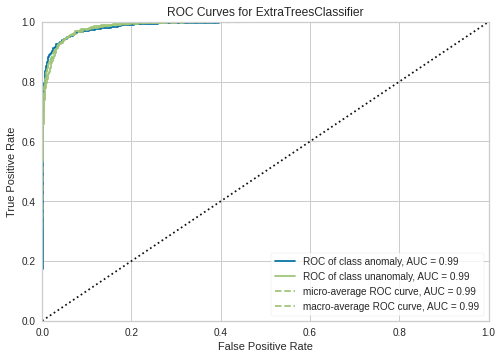

In [83]:
plot_model(tuned_et, plot = 'auc')

#### Precision-Recall Curve

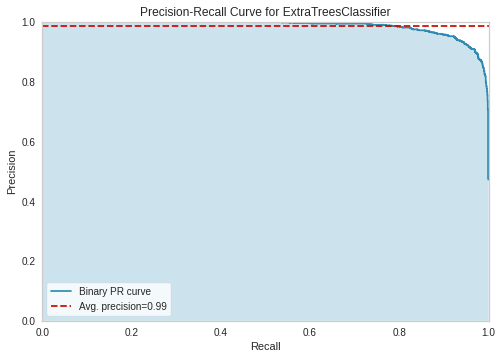

In [84]:
plot_model(tuned_et, plot = 'pr')

#### Feature Importance Plot

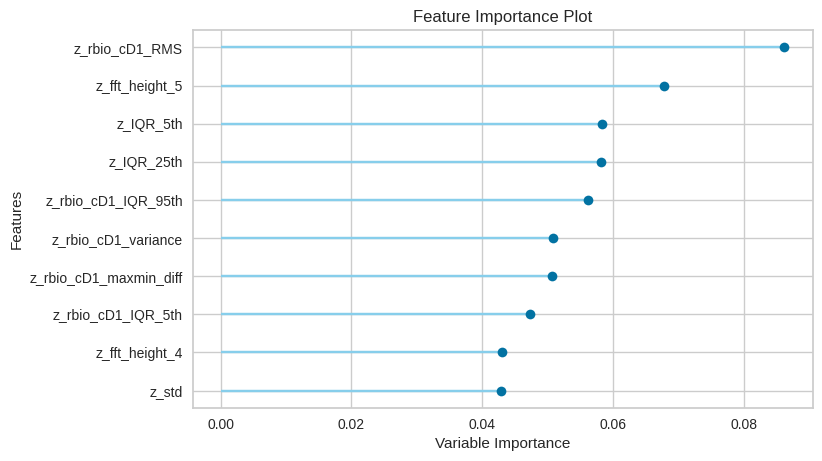

In [85]:
plot_model(tuned_et, plot='feature')

#### Confusion Matrix

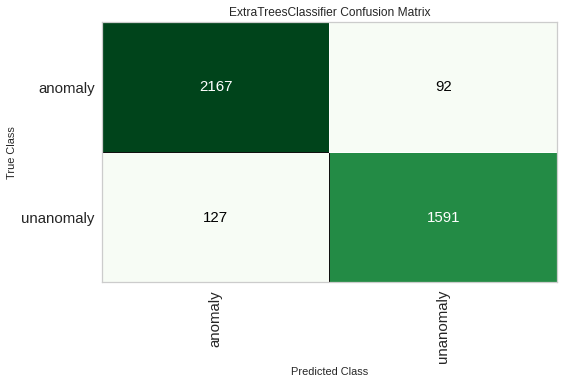

In [86]:
plot_model(tuned_et, plot = 'confusion_matrix')

In [87]:
evaluate_model(tuned_et)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Predict on test

In [88]:
predict_model(tuned_et);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9449,0.9888,0.9261,0.9453,0.9356,0.8875,0.8877


## Predict on unseen data

In [ ]:
unseen_predictions = predict_model(tuned_et, data=data_unseen)
unseen_predictions.head()

In [ ]:
from pycaret.utils import check_metric
check_metric(unseen_predictions['Anomaly_labels'], unseen_predictions['Label'], metric = 'Accuracy')

## Saving the model

In [97]:
save_model(tuned_et,'Final et Model 1APR2022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['x_mean', 'y_mean',
                                                           'z_mean', 'x_std',
                                                           'y_std', 'z_std',
                                                           'x_min', 'y_min',
                                                           'z_min', 'x_max',
                                                           'y_max', 'z_max',
                                                           'x_maxmin_diff',
                                                           'y_maxmin_diff',
                                                           'z_maxmi

# Random Forest Classifier


### train

In [93]:
rf= create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9504,0.9918,0.9581,0.9306,0.9442,0.8996,0.8999
1,0.9429,0.9885,0.9187,0.9491,0.9337,0.8835,0.8839
2,0.9418,0.9910,0.9557,0.9151,0.9349,0.8824,0.8830
3,0.9461,0.9875,0.9312,0.9451,0.9381,0.8904,0.8905
4,0.9504,0.9916,0.9484,0.9392,0.9438,0.8995,0.8995
5,0.9353,0.9836,0.9140,0.9370,0.9254,0.8684,0.8686
6,0.9429,0.9867,0.9189,0.9492,0.9338,0.8836,0.8840
7,0.9407,0.9858,0.9433,0.9229,0.9330,0.8798,0.8799
8,0.9450,0.9894,0.9335,0.9404,0.9370,0.8882,0.8882


In [94]:
print(rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


### Tune 

In [95]:
tuned_rf = tune_model(rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9440,0.9898,0.9680,0.9097,0.9379,0.8870,0.8884
1,0.9418,0.9872,0.9261,0.9400,0.9330,0.8816,0.8817
2,0.9397,0.9896,0.9680,0.9014,0.9335,0.8784,0.8803
3,0.9429,0.9877,0.9386,0.9317,0.9351,0.8841,0.8841
4,0.9440,0.9903,0.9533,0.9216,0.9372,0.8866,0.8871
5,0.9397,0.9822,0.9386,0.9249,0.9317,0.8777,0.8777
6,0.9386,0.9857,0.9238,0.9353,0.9295,0.8751,0.8752
7,0.9245,0.9851,0.9458,0.8889,0.9165,0.8477,0.8491
8,0.9471,0.9887,0.9458,0.9343,0.9400,0.8928,0.8928


In [96]:
print(tuned_rf)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=4, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0005,
                       min_impurity_split=None, min_samples_leaf=3,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=260, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)


### plot model

#### AUC Plot

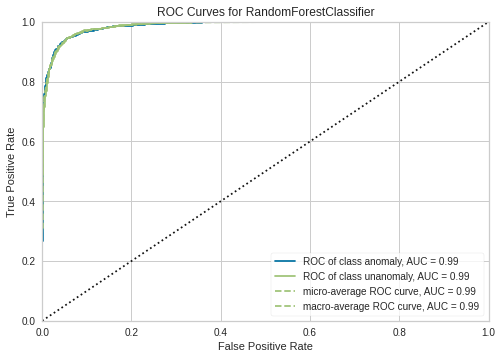

In [98]:
plot_model(tuned_rf, plot = 'auc')

#### Precision-Recall Curve

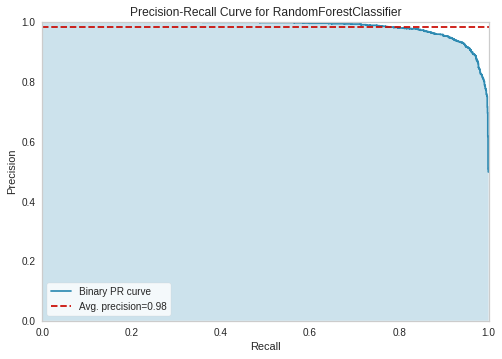

In [99]:
plot_model(tuned_rf, plot = 'pr')

#### Feature Importance Plot

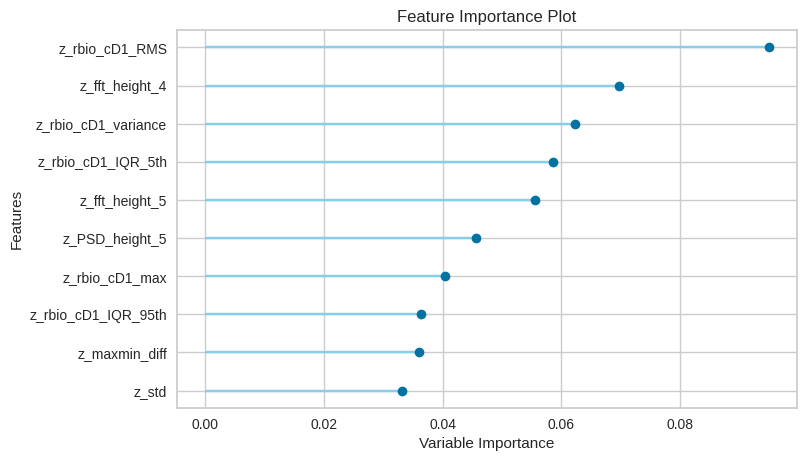

In [100]:
plot_model(tuned_rf, plot='feature')

#### Confusion Matrix

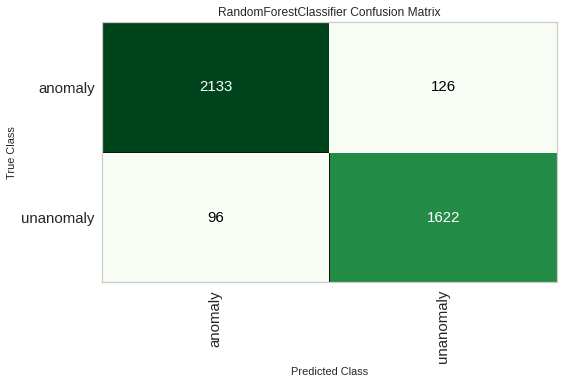

In [101]:
plot_model(tuned_rf, plot = 'confusion_matrix')

In [102]:
evaluate_model(tuned_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Predict on test

In [103]:
predict_model(tuned_rf);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9442,0.987,0.9441,0.9279,0.9359,0.8865,0.8866


## Predict on unseen data

In [104]:
unseen_predictions = predict_model(tuned_rf, data=data_unseen)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0,0.9861,0,0,0,0,0


,x_mean,y_mean,z_mean,x_std,y_std,z_std,x_min,y_min,z_min,x_max,...,y_rbio_cD3_no_mean_cross,y_rbio_cD2_no_mean_cross,y_rbio_cD1_no_mean_cross,z_rbio_cA1_no_mean_cross,z_rbio_cD3_no_mean_cross,z_rbio_cD2_no_mean_cross,z_rbio_cD1_no_mean_cross,Anomaly_labels,Label,Score
0,-1.351327e-35,-8.769952e-20,-0.005619,2.292782e-33,9.534050e-17,0.075609,-7.377940e-33,-2.234549e-16,-0.180347,9.489779e-33,...,14,0,50,0,14,26,27,unanomaly,unanomaly,0.9872
1,5.568117e-35,5.995205e-19,0.000068,2.578544e-33,9.828586e-17,0.077215,-8.482967e-33,-2.467191e-16,-0.187601,7.355724e-33,...,0,26,0,13,14,1,49,unanomaly,unanomaly,0.9872
2,-7.888923e-35,4.411562e-18,-0.000973,3.144209e-33,1.005174e-16,0.082065,-1.792687e-32,-2.517351e-16,-0.206829,1.085135e-32,...,14,0,0,0,1,11,46,unanomaly,unanomaly,0.9872
3,-9.868909e-35,6.068972e-18,-0.000434,3.656389e-33,8.767127e-17,0.081121,-1.116904e-32,-1.811297e-16,-0.148229,1.289373e-32,...,14,26,0,14,0,4,47,unanomaly,unanomaly,0.9872
4,2.869420e-35,-7.131838e-19,-0.001169,2.668936e-33,9.186408e-17,0.072127,-6.716537e-33,-2.306965e-16,-0.180781,8.564323e-33,...,14,0,50,0,14,8,25,unanomaly,unanomaly,0.9872


In [105]:
from pycaret.utils import check_metric
check_metric(unseen_predictions['Anomaly_labels'], unseen_predictions['Label'], metric = 'Accuracy')

0.946

## Saving the model

In [106]:
save_model(tuned_rf,'Final rf Model 1APR2022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['x_mean', 'y_mean',
                                                           'z_mean', 'x_std',
                                                           'y_std', 'z_std',
                                                           'x_min', 'y_min',
                                                           'z_min', 'x_max',
                                                           'y_max', 'z_max',
                                                           'x_maxmin_diff',
                                                           'y_maxmin_diff',
                                                           'z_maxmi

# Light Gradient Boosting Machine

### train

In [107]:
lightgbm= create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9580,0.9936,0.9631,0.9422,0.9525,0.9148,0.9150
1,0.9418,0.9894,0.9163,0.9490,0.9323,0.8813,0.8817
2,0.9461,0.9916,0.9557,0.9238,0.9395,0.8909,0.8914
3,0.9504,0.9887,0.9435,0.9435,0.9435,0.8993,0.8993
4,0.9537,0.9925,0.9558,0.9396,0.9476,0.9061,0.9062
5,0.9321,0.9824,0.9140,0.9300,0.9219,0.8619,0.8620
6,0.9418,0.9886,0.9140,0.9514,0.9323,0.8813,0.8819
7,0.9396,0.9873,0.9458,0.9187,0.9320,0.8777,0.8780
8,0.9450,0.9894,0.9335,0.9404,0.9370,0.8882,0.8882


In [108]:
print(lightgbm)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


### Tune 

In [109]:
tuned_lightgbm = tune_model(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9591,0.9932,0.9631,0.9444,0.9537,0.9170,0.9171
1,0.9504,0.9901,0.9261,0.9592,0.9424,0.8989,0.8993
2,0.9472,0.9916,0.9557,0.9260,0.9406,0.8931,0.8935
3,0.9461,0.9879,0.9410,0.9364,0.9387,0.8906,0.8907
4,0.9526,0.9915,0.9459,0.9459,0.9459,0.9037,0.9037
5,0.9353,0.9816,0.9238,0.9284,0.9261,0.8686,0.8686
6,0.9407,0.9879,0.9115,0.9513,0.9310,0.8791,0.8797
7,0.9353,0.9880,0.9409,0.9139,0.9272,0.8690,0.8693
8,0.9439,0.9891,0.9286,0.9425,0.9355,0.8859,0.8859


In [110]:
print(tuned_lightgbm)

LGBMClassifier(bagging_fraction=0.7, bagging_freq=6, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=66, min_child_weight=0.001, min_split_gain=0.4,
               n_estimators=90, n_jobs=-1, num_leaves=90, objective=None,
               random_state=123, reg_alpha=0.0005, reg_lambda=0.1,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


### plot model

#### AUC Plot

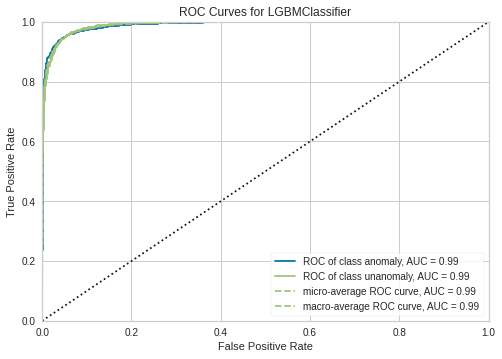

In [111]:
plot_model(tuned_lightgbm, plot = 'auc')

#### Precision-Recall Curve

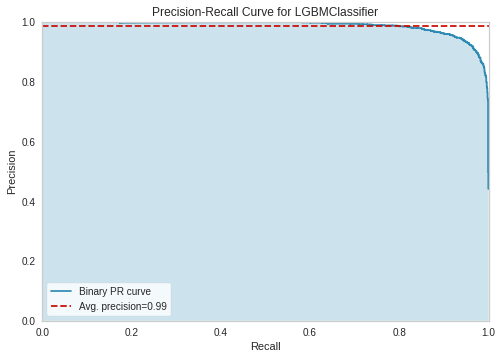

In [112]:
plot_model(tuned_lightgbm, plot = 'pr')

#### Feature Importance Plot

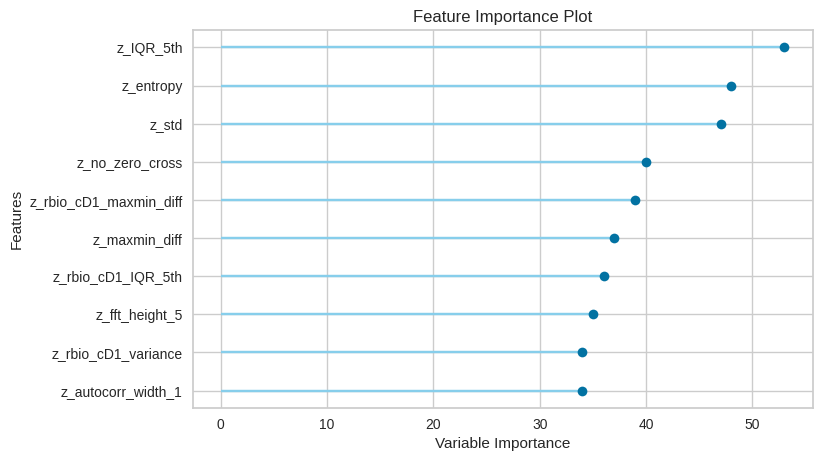

In [113]:
plot_model(tuned_lightgbm, plot='feature')

#### Confusion Matrix

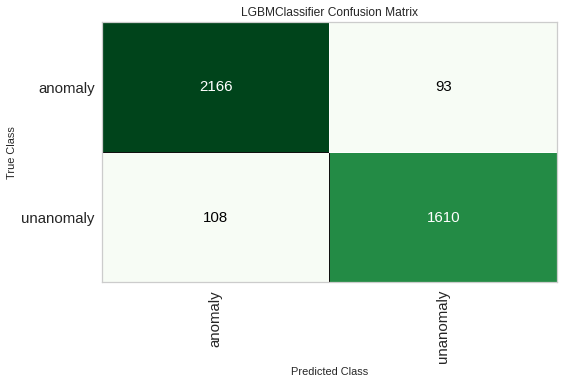

In [114]:
plot_model(tuned_lightgbm, plot = 'confusion_matrix')

In [115]:
evaluate_model(tuned_lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Predict on test

In [116]:
predict_model(tuned_lightgbm);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9495,0.9895,0.9371,0.9454,0.9412,0.8969,0.8969


## Predict on unseen data

In [117]:
unseen_predictions = predict_model(tuned_lightgbm, data=data_unseen)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0,0.9884,0,0,0,0,0


,x_mean,y_mean,z_mean,x_std,y_std,z_std,x_min,y_min,z_min,x_max,...,y_rbio_cD3_no_mean_cross,y_rbio_cD2_no_mean_cross,y_rbio_cD1_no_mean_cross,z_rbio_cA1_no_mean_cross,z_rbio_cD3_no_mean_cross,z_rbio_cD2_no_mean_cross,z_rbio_cD1_no_mean_cross,Anomaly_labels,Label,Score
0,-1.351327e-35,-8.769952e-20,-0.005619,2.292782e-33,9.534050e-17,0.075609,-7.377940e-33,-2.234549e-16,-0.180347,9.489779e-33,...,14,0,50,0,14,26,27,unanomaly,unanomaly,0.9996
1,5.568117e-35,5.995205e-19,0.000068,2.578544e-33,9.828586e-17,0.077215,-8.482967e-33,-2.467191e-16,-0.187601,7.355724e-33,...,0,26,0,13,14,1,49,unanomaly,unanomaly,0.9999
2,-7.888923e-35,4.411562e-18,-0.000973,3.144209e-33,1.005174e-16,0.082065,-1.792687e-32,-2.517351e-16,-0.206829,1.085135e-32,...,14,0,0,0,1,11,46,unanomaly,unanomaly,0.9995
3,-9.868909e-35,6.068972e-18,-0.000434,3.656389e-33,8.767127e-17,0.081121,-1.116904e-32,-1.811297e-16,-0.148229,1.289373e-32,...,14,26,0,14,0,4,47,unanomaly,unanomaly,0.9999
4,2.869420e-35,-7.131838e-19,-0.001169,2.668936e-33,9.186408e-17,0.072127,-6.716537e-33,-2.306965e-16,-0.180781,8.564323e-33,...,14,0,50,0,14,8,25,unanomaly,unanomaly,0.9998


In [118]:
from pycaret.utils import check_metric
check_metric(unseen_predictions['Anomaly_labels'], unseen_predictions['Label'], metric = 'Accuracy')

0.9469

## Saving the model

In [120]:
save_model(tuned_lightgbm,'Final lightgbm Model 1APR2022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['x_mean', 'y_mean',
                                                           'z_mean', 'x_std',
                                                           'y_std', 'z_std',
                                                           'x_min', 'y_min',
                                                           'z_min', 'x_max',
                                                           'y_max', 'z_max',
                                                           'x_maxmin_diff',
                                                           'y_maxmin_diff',
                                                           'z_maxmi